In [60]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

In [175]:
class Cellular_plots_model:

    def __init__(self, n_steps, n_types, n_cells, nx=40, T=1, k=0.5, lamda=1, equilibrium_area=5):

        self.n_steps = n_steps
        self.n_types = n_types
        self.n_cells = n_cells

        self.nx = nx
        self.T = T
        self.k = k
        self.lamda = lamda
        self.equilibrium_area = equilibrium_area
        
        self.initialize_grid_fixed()
        self.initialize_cell_sizes()

        self.step = 0

        if n_types != 3:
            raise Exception("Error: Current J function only accepts 3 types: the M type and two others")

        # M=0, d=1, l=2 
        # Each row has index 0: type_min, index 1: type_max, index 2: J value
        # J values obtained from Glazer 2013. The report did not specify the
        # J value for M, M 
        self.J_table = {
            frozenset((0,0)): 0, 
            frozenset((1,1)): 2,
            frozenset((1,2)): 11,
            frozenset((2,2)): 14,
            frozenset((0,1)): 16,
            frozenset((0,2)): 16,
        }

        self.initialize_rands()

    def initialize_grid_random(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2), dtype=int)


        for cell_ID in range(1, self.n_cells + 1):

            # Pick a random latice site which is not yet occupied
            while True:

                # Pick random lattice site
                i, j = np.random.randint(1, self.nx, 2)

                if self.grid[i, j] == 0:
                    break
                
            cell_type = np.random.choice(np.arange(1, self.n_types))

            self.grid[i, j] = cell_ID
    
    def initialize_grid_fixed(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2), dtype=int)
        
        cells_per_row = int(np.sqrt(self.n_cells))
        cell_width = cell_height = int(np.sqrt(self.equilibrium_area))

        initial_index_i = int((self.nx - np.sqrt(self.n_cells * self.equilibrium_area)) * 0.5)
        initial_index_j = initial_index_i

        self.types = {0: 0}

        for cell_ID in range(1, self.n_cells + 1):
            
            self.types[cell_ID] = np.random.choice(np.arange(1, self.n_types))
  
            # Translate cell ID to a column and row value
            cell_row = (cell_ID - 1) % cells_per_row
            cell_column = (cell_ID - 1) // cells_per_row

            i = initial_index_i + cell_column * cell_width
            j = initial_index_j + cell_row * cell_height
            
            self.grid[i : i + cell_width, j : j + cell_height] = cell_ID

    def initialize_cell_sizes(self):
        
        # key: cell_ID, value: cell_size
        self.cell_sizes = {}

        for cell_ID in np.unique(self.grid):

            count = np.count_nonzero(self.grid == cell_ID)

            self.cell_sizes[cell_ID] = count

    def cell_type(self, cell_ID):
        return self.types[cell_ID]

    def run(self):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % 10000 == 0:
                print(f"Step: {self.step}", end="\r")
    
    def initialize_rands(self, n=1000000):
        self.rand_index = n
        self.rands = np.random.uniform(size=n)

    def get_rand(self):
        if self.rand_index < 0:
            self.initialize_rands()
        self.rand_index -= 1
        return self.rands[self.rand_index]

    def update(self):
        # Pick random lattice site
        i, j = int((self.nx-1)*self.get_rand()+1), int((self.nx-1)*self.get_rand()+1) 
        cell_ID = self.grid[i, j]
        cell_type = self.cell_type(cell_ID) 

        # Pick a random neighbour
        von_neumann_neighbourhood = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j-1)]
        von_neumann_index = int(len(von_neumann_neighbourhood)*self.get_rand()) 
        neighbour_i, neighbour_j = von_neumann_neighbourhood[von_neumann_index]

        neighbour_ID = self.grid[neighbour_i, neighbour_j]
        neighbour_type = self.cell_type(neighbour_ID) 

        if cell_ID == neighbour_ID:
            self.step += 1
            return
        
        # Compute hamiltonian vol before updating the lattice site
        old_ham_vol = self.calc_hamiltonian_vol([cell_ID, neighbour_ID])

        # Update cell sizes
        self.cell_sizes[neighbour_ID] += 1
        self.cell_sizes[cell_ID] -= 1

        # Calculate the new hamiltonian vol with updated cell sizes
        new_ham_vol = self.calc_hamiltonian_vol([cell_ID, neighbour_ID])

        delta_ham_bond = self.calc_delta_hamiltonian_bond(self.grid, i, j, cell_ID, cell_type, neighbour_ID, neighbour_type)

        delta_hamiltonian = (new_ham_vol - old_ham_vol) + delta_ham_bond
        
        if delta_hamiltonian < 0 or self.get_rand() < np.exp(-delta_hamiltonian/(self.k * self.T)):
            
            # Update grid
            self.grid[i, j] = neighbour_ID

        else:
            # Reset cell size changes
            self.cell_sizes[neighbour_ID] -= 1
            self.cell_sizes[cell_ID] += 1

        self.step += 1
      
    def calc_hamiltonian_vol(self, cell_IDs):

        sigma = 0
        for cell_ID in cell_IDs:

            if cell_ID == 0:
                continue

            cell_area = self.cell_sizes[cell_ID]
            sigma += (cell_area - self.equilibrium_area) ** 2

        return self.lamda * sigma

    def calc_delta_hamiltonian_bond(self, grid, i, j, cell_ID1, cell_type1, cell_ID2, cell_type2):

        old_ham = self.calc_hamiltonian_bond_new_implemetation(grid, i, j, cell_ID1, cell_type1)
        new_ham = self.calc_hamiltonian_bond_new_implemetation(grid, i, j, cell_ID2, cell_type2)

        # Twice since the lattice site in the Moore neighbourhood are also affected
        return 2 * (new_ham - old_ham)

    def calc_hamiltonian_bond_new_implemetation(self, grid, i, j, cell_ID, cell_type):
        
        H_bond = 0
        for i_offset in [-1, 0, 1]:
            for j_offset in [-1, 0, 1]:

                if i_offset == 0 and j_offset == 0:
                    continue
                    
                i_prime = i + i_offset
                j_prime = j + j_offset
                
                cell_prime_ID = grid[i_prime, j_prime]
                cell_prime_type = self.cell_type(cell_prime_ID)
                
                J = self.J(cell_type, cell_prime_type)
                kronecker_delta = self.kronecker_delta(cell_ID, cell_prime_ID)

                H_bond += J * (1 - kronecker_delta)

        return H_bond
    
    def calc_boundary_lengths(self):
        lengths = dict.fromkeys(self.J_table.keys(), 0)
        
        H_bond = 0
        for i in range(1, self.grid.shape[0] - 1):
            for j in range(1, self.grid.shape[1] - 1):
                cell_ID = self.grid[i, j]
                cell_type = self.cell_type(cell_ID)

                for i_offset in [-1, 0, 1]:
                    for j_offset in [-1, 0, 1]:

                        if i_offset == 0 and j_offset == 0:
                            continue

                        i_prime = i + i_offset
                        j_prime = j + j_offset

                        cell_prime_ID = self.grid[i_prime, j_prime]
                        cell_prime_type = self.cell_type(cell_prime_ID)

                        if cell_ID != cell_prime_ID:
                            lengths[frozenset((cell_type, cell_prime_type))] += 0.5

        return lengths
        
    def J(self, type1, type2):

        return self.J_table[frozenset((type1, type2))]
          
    def kronecker_delta(self, value1, value2):

        if value1 == value2:
            return 1

        return 0

    def show_grid_every_x_steps(self, x):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % x == 0:
                self.show_grid(clear_plot=True)
           
    def show_grid(self, clear_plot=False):
        
        if clear_plot:
            clear_output(wait=True)
        
        grid2 = np.stack([np.array(self.grid, dtype=float), np.vectorize(self.cell_type)(self.grid)], axis=-1)

        # For plotting purposes set M cells to None
        grid2[grid2==0] = np.nan
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        fig.suptitle(f"Step: {self.step}")

        ax1.matshow(grid2[1:-1, 1:-1, 0], cmap='hsv')
        ax1.set_title("Cell IDs")

        ax2.matshow(grid2[1:-1, 1:-1, 1], cmap="magma")
        ax2.set_title("Cell types")
        
        plt.tight_layout()
        plt.show()
        
    def plot_boundary_lengths(self, n_points):
        b_values = []
        f_values = []
        
        while self.step < self.n_steps+1:
            if self.step % (self.n_steps // n_points) == 0:
                print(self.step, end='\r')
                boundaries = self.calc_boundary_lengths().values()
                b_values.append(sum(boundaries))
                f_values.append(list(boundaries))
                
            self.update()
                
        plt.plot(np.linspace(0, self.n_steps+1, n_points+1), b_values)
        plt.xlabel("Steps")
        plt.ylabel("Total boundary length")
        plt.show()

        plt.plot(np.linspace(0, self.n_steps+1, n_points+1), np.array(f_values)/np.array(b_values)[:,None])
        plt.xlabel("Steps")
        plt.ylabel("Fractional length")
        plt.legend([list(key) for key in self.calc_boundary_lengths().keys()])
        plt.show()

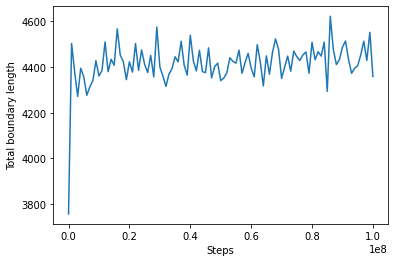

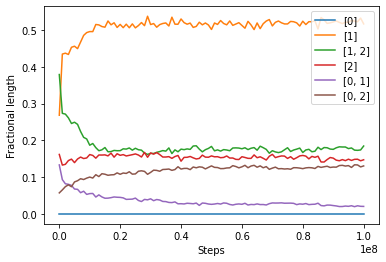

In [177]:
model = Cellular_plots_model(n_steps=100000000, n_types=3, n_cells=100, nx=100, equilibrium_area=40, T=20, lamda=1, k=1)
# print(model.calc_boundary_lengths())
# model.show_grid()
# model.show_grid_every_x_steps(100000)

model.plot_boundary_lengths(100)

In [178]:
model = Cellular_plots_model(n_steps=100000000, n_types=3, n_cells=100, nx=100, equilibrium_area=40, T=20, lamda=1, k=1)
# print(model.calc_boundary_lengths())
model.show_grid()
model.show_grid_every_x_steps(100000)

KeyboardInterrupt: 